In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import cross_validation

from sklearn import tree

%matplotlib inline

In [171]:
df = pd.read_csv('train.csv')

In [172]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## First thing is we want to quantify our outcomes with the get_dummies method, this will allow us to clearly plot out the animals that were euthanized or adopted, I also like to lower the columns in order to work with some cleaner data

In [173]:
df_outcome = pd.get_dummies(df['OutcomeType'])
df = pd.concat([df, df_outcome], axis=1)

In [174]:
df.columns = map(lambda x: x.lower(), df.columns)

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 15 columns):
animalid           26729 non-null object
name               19038 non-null object
datetime           26729 non-null object
outcometype        26729 non-null object
outcomesubtype     13117 non-null object
animaltype         26729 non-null object
sexuponoutcome     26728 non-null object
ageuponoutcome     26711 non-null object
breed              26729 non-null object
color              26729 non-null object
adoption           26729 non-null float64
died               26729 non-null float64
euthanasia         26729 non-null float64
return_to_owner    26729 non-null float64
transfer           26729 non-null float64
dtypes: float64(5), object(10)
memory usage: 3.1+ MB


### Create a barplot of the animals to take a look at most popular outcomes and also convert datetime to a datetime object

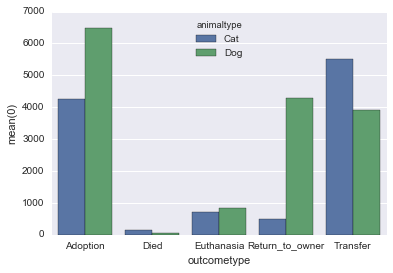

In [176]:
test = df[['animaltype','outcometype','breed']].groupby(['animaltype','outcometype']).size().reset_index()
df.datetime = pd.to_datetime(df.datetime)
sns.barplot(x='outcometype',y=0,hue='animaltype',data=test)

### One of the first things that I realized was that 'mixed breeds' and nonmixed breeds had almost nothing different when aggregating. I wrote this function to remove the 'Mixed' keyword and convert to the nonmixed breed.

In [177]:
def remove_mix(item):
    if 'Mix' in item:
        x = item.split(' ')
        return ' '.join(x[:len(x)-1])
    else:
        return item
    
#remove_mix('Shetland Sheepdog Mix')

df['breed'] = df['breed'].apply(remove_mix)

### I'd like to create several features mapped based on the breed for my predictive model. My plan is normalize using a z-score, and calculate th percentage breakdown for each pc. It would be interesting to see if there is breed stigma from users.

In [178]:
aggregations = {
    'adoption':'sum',
    'died':'sum',
    'euthanasia':'sum',
    'return_to_owner':'sum',
    'transfer':'sum'
    }

animal_agg = df.groupby(['breed','animaltype']).agg(aggregations).reset_index()
#dog_breed = df[df.animaltype == 'Dog'].groupby(['breed']).agg(aggregations).reset_index()
#cat_breed = df[df.animaltype == 'Cat'].groupby(['breed']).agg(aggregations).reset_index()

In [179]:
animal_agg['total'] = animal_agg.sum(axis=1)
animal_agg['total_normalized'] = animal_agg['total'].values.astype(float)
animal_agg['zscore'] = (animal_agg.total_normalized - animal_agg.total_normalized.mean())/animal_agg.total_normalized.std(ddof=0)
animal_agg['transfer_pc'] = animal_agg.transfer / animal_agg.total * 100
animal_agg['adoption_pc'] = animal_agg.adoption / animal_agg.total * 100
animal_agg['rto_pc'] = animal_agg.return_to_owner / animal_agg.total * 100
animal_agg['died_pc'] = animal_agg.died / animal_agg.total * 100
animal_agg['euth_pc'] = animal_agg.euthanasia / animal_agg.total * 100
animal_agg = animal_agg.round(2)

In [180]:
'''cat_breed['total'] = cat_breed.sum(axis=1)
cat_breed['total_normalized'] = cat_breed['total'].values.astype(float)
cat_breed['zscore'] = (cat_breed.total_normalized - cat_breed.total_normalized.mean())/cat_breed.total_normalized.std(ddof=0)
cat_breed['transfer_pc'] = cat_breed.transfer / cat_breed.total * 100
cat_breed['adoption_pc'] = cat_breed.adoption / cat_breed.total * 100
cat_breed['rto_pc'] = cat_breed.return_to_owner / cat_breed.total * 100
cat_breed['died_pc'] = cat_breed.died / cat_breed.total * 100
cat_breed['euth_pc'] = cat_breed.euthanasia / cat_breed.total * 100
dog_breed['total'] = dog_breed.sum(axis=1)
dog_breed['total_normalized'] = dog_breed['total'].values.astype(float)
dog_breed['zscore'] = (dog_breed.total_normalized - dog_breed.total_normalized.mean())/dog_breed.total_normalized.std(ddof=0)
dog_breed['transfer_pc'] = dog_breed.transfer / dog_breed.total * 100
dog_breed['adoption_pc'] = dog_breed.adoption / dog_breed.total * 100
dog_breed['rto_pc'] = dog_breed.return_to_owner / dog_breed.total * 100
dog_breed['died_pc'] = dog_breed.died / dog_breed.total * 100
dog_breed['euth_pc'] = dog_breed.euthanasia / dog_breed.total * 100
dog_breed_perc = dog_breed[['breed','transfer_pc','adoption_pc','rto_pc','died_pc','euth_pc','total', 'zscore']]
cat_breed_perc = cat_breed[['breed','transfer_pc','adoption_pc','rto_pc','died_pc','euth_pc','total', 'zscore']]
dog_breed_perc = dog_breed_perc.round(2)
cat_breed_perc = cat_breed_perc.round(2)

'''

"cat_breed['total'] = cat_breed.sum(axis=1)\ncat_breed['total_normalized'] = cat_breed['total'].values.astype(float)\ncat_breed['zscore'] = (cat_breed.total_normalized - cat_breed.total_normalized.mean())/cat_breed.total_normalized.std(ddof=0)\ncat_breed['transfer_pc'] = cat_breed.transfer / cat_breed.total * 100\ncat_breed['adoption_pc'] = cat_breed.adoption / cat_breed.total * 100\ncat_breed['rto_pc'] = cat_breed.return_to_owner / cat_breed.total * 100\ncat_breed['died_pc'] = cat_breed.died / cat_breed.total * 100\ncat_breed['euth_pc'] = cat_breed.euthanasia / cat_breed.total * 100\ndog_breed['total'] = dog_breed.sum(axis=1)\ndog_breed['total_normalized'] = dog_breed['total'].values.astype(float)\ndog_breed['zscore'] = (dog_breed.total_normalized - dog_breed.total_normalized.mean())/dog_breed.total_normalized.std(ddof=0)\ndog_breed['transfer_pc'] = dog_breed.transfer / dog_breed.total * 100\ndog_breed['adoption_pc'] = dog_breed.adoption / dog_breed.total * 100\ndog_breed['rto_pc'] = 

In [181]:
df = pd.merge(df, animal_agg, left_on='breed',right_on='breed',how='inner')

In [182]:
df = df[['datetime','outcometype','outcomesubtype','animaltype_x','sexuponoutcome','ageuponoutcome','breed','color','adoption_x','died_x','euthanasia_x','return_to_owner_x','transfer_x','total','zscore','transfer_pc','adoption_pc','rto_pc','died_pc','euth_pc']]

In [183]:
df.columns = df.columns.str.replace('_x','')

In [184]:
df = df.fillna('None')
df.color.value_counts()
colors = pd.DataFrame(df.color.str.split('/').tolist(), columns=['color1','color2'])
df = pd.concat([df, colors],axis=1)
df = df.drop('color',axis=1)

In [185]:
def convert_dates(cell):
    if 'year' in cell:
        year = cell.split(' ')[0]
        year = float(year)
        year = year * 365
        return year
    elif 'month' in cell:
        months = cell.split(' ')[0]
        months = float(months)
        months = months * 30
        return months
    elif 'week' in cell:
        weeks = cell.split(' ')[0]
        weeks = float(weeks)
        weeks = weeks * 7
        return weeks
    elif 'day' in cell:
        days = cell.split(' ')[0]
        days = float(days)
        return days
    else:
        return 0

df['days_alive'] = df['ageuponoutcome'].apply(convert_dates)
df['years_alive'] = df['days_alive']/365
df['weeks_alive'] = df['days_alive']/52
df['months_alive'] = df['days_alive']/12

In [186]:
df.columns = map(lambda x: x.lower(), df.columns)
df.head()

,datetime,outcometype,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,adoption,died,euthanasia,...,adoption_pc,rto_pc,died_pc,euth_pc,color1,color2,days_alive,years_alive,weeks_alive,months_alive
0,2014-02-12 18:22:00,Return_to_owner,None,Dog,Neutered Male,1 year,Shetland Sheepdog,0.0,0.0,0.0,...,18.52,40.74,0.0,11.11,Brown,White,365.0,1.000000,7.019231,30.416667
1,2014-11-08 19:01:00,Return_to_owner,None,Dog,Spayed Female,10 years,Shetland Sheepdog,0.0,0.0,0.0,...,18.52,40.74,0.0,11.11,Brown,White,3650.0,10.000000,70.192308,304.166667
2,2015-06-27 15:16:00,Transfer,Partner,Dog,Intact Male,2 years,Shetland Sheepdog,0.0,0.0,0.0,...,18.52,40.74,0.0,11.11,Tricolor,None,730.0,2.000000,14.038462,60.833333
3,2015-05-28 17:30:00,Adoption,None,Dog,Spayed Female,5 months,Shetland Sheepdog,1.0,0.0,0.0,...,18.52,40.74,0.0,11.11,White,Tan,150.0,0.410959,2.884615,12.500000
4,2014-10-12 13:58:00,Transfer,Partner,Dog,Intact Male,2 years,Shetland Sheepdog,0.0,0.0,0.0,...,18.52,40.74,0.0,11.11,Sable,White,730.0,2.000000,14.038462,60.833333


In [188]:
'''features = ["limit_bal","sex","education","marriage","age","pay_0",
           "pay_2","pay_3","pay_4","pay_5","pay_6",
           "bill_amt1","bill_amt2","bill_amt3","bill_amt4","bill_amt5",
           "bill_amt6","pay_amt1","pay_amt2","pay_amt3","pay_amt4",
           "pay_amt5","pay_amt6"]
response = 'default_payment_next_month'
'''

fc = df.copy()

x = df.columns.tolist()
fc = fc.drop('datetime',axis=1)
fc = fc.drop('outcometype', axis=1)
fc = fc.drop('ageuponoutcome', axis=1)
fc = fc.drop('outcomesubtype', axis=1)
fc = fc.drop('color1', axis=1)
fc = fc.drop('color2', axis=1)
fc = fc.drop('adoption',axis=1)
fc = fc.drop('died',axis=1)
fc = fc.drop('return_to_owner',axis=1)
fc = fc.drop('transfer',axis=1)
fc = fc.drop('total', axis=1)
fc = fc.drop('euthanasia',axis=1)
fc.columns
fc = pd.get_dummies(fc)
features = fc.columns.tolist()
fc = pd.concat([fc, df.outcometype],axis=1)

In [189]:
'''df.animaltype = df.animaltype.astype('category')
df.breed = df.breed.astype('category')
df.sexuponoutcome = df.sexuponoutcome.astype('category')
df.color1 = df.color1.astype('category')
df.color2 = df.color2.astype('category')
'''

"df.animaltype = df.animaltype.astype('category')\ndf.breed = df.breed.astype('category')\ndf.sexuponoutcome = df.sexuponoutcome.astype('category')\ndf.color1 = df.color1.astype('category')\ndf.color2 = df.color2.astype('category')\n"

In [190]:
np.random.seed(seed = 2)
random_idx = np.random.rand(fc.shape[0])

In [191]:
train = fc[random_idx < 0.6]
test = fc[random_idx >=.6]

In [198]:
response = 'outcometype'

In [199]:
params_model = {'max_depth':10,
               'criterion': 'gini'}
params_fitting = {'X': train[features],
                 'y': train[response]}

dt_model= DecisionTreeClassifier(**params_model).fit(**params_fitting)

In [200]:
dt_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [201]:
params_predict = {'X': test[features]}
y_predict = dt_model.predict(**params_predict)
y_actual = test[response].values

acc = metrics.accuracy_score(y_actual, y_predict)
print "accuracy is: {}".format(round(acc,2))

accuracy is: 0.65


In [202]:
range_depth = np.arange(1,30,1)
range_leaf_samples = np.arange(1,25,1)

num_sampling = 100

opt_score = 0
opt_depth = 0
opt_leaf_samples = 0

In [203]:
import random

for id_sample, sample in enumerate(range(num_sampling)):
    
    depth = random.sample(range_depth, 1)[0]
    leaf_samples = random.sample(range_leaf_samples, 1)[0]
    split_samples = random.sample(range_leaf_samples, 1)[0]
    
    params_model = {'max_depth':depth,
                 'min_samples_leaf':leaf_samples,
                 'min_samples_split':split_samples,
                 'criterion':'gini'}
    
    dt_model = DecisionTreeClassifier(**params_model)
    
    params_cross_val = {'estimator':dt_model,
                       'X': train[features],
                       'y': train[response],
                       'cv':5}
    scores = cross_validation.cross_val_score(**params_cross_val)
    score_mean = scores.mean()
    
    if score_mean > opt_score:
        opt_score = score_mean
        opt_depth = depth
        opt_leaf_samples = leaf_samples
        
print 'optimal score {}'.format(round(opt_score,3))
print 'opt depth {}'.format(opt_depth)
print 'optimal leaf samples {}'.format(opt_leaf_samples)

optimal score 0.506
opt depth 9
optimal leaf samples 14


In [159]:
params_model_opt = {'max_depth': opt_depth,
                   'min_samples_leaf': opt_leaf_samples,
                   'criterion':'gini'}
params_fitting = {'X': test[features],
                 'y':test[response]}

opt_dt_model = DecisionTreeClassifier(**params_model_opt).fit(**params_fitting)

dic_tree_graph = {'decision_tree': opt_dt_model,
                 'out_file': 'dogs_cats.dot',
                 'feature_names':features}
tree.export_graphviz(**dic_tree_graph)

In [160]:
ls

dogs_cats.dot    dogs_cats.ipynb  test.csv         train.csv
